**МЛ Практика 4: Задача классификации**

**1: Загрузка библиотек и предобратка данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Загрузка набора данных
df = pd.read_csv('content/income.csv')
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [3]:
# Проверка на пропущенные значения
print(df.isnull().sum())

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64


In [4]:
# Удаление строк с пропусками
df_drop = df.dropna()
print("\n# Удаление строк с пропусками")
print(df_drop.isnull().sum()) # пропусков нет


# Удаление строк с пропусками
age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income >50K       0
dtype: int64


In [5]:
df['income >50K'] = df['income >50K'].astype('category')
df['workclass'] = df['workclass'].astype('category')
df['education'] = df['education'].astype('category')
df['marital-status'] = df['marital-status'].astype('category')
df['occupation'] = df['occupation'].astype('category')
df['relationship'] = df['relationship'].astype('category')
df['race'] = df['race'].astype('category')
df['sex'] = df['sex'].astype('category')
df['native-country'] = df['native-country'].astype('category')

In [6]:
Y = df['income >50K'] # выбираем целевую переменную (категориальную)
X = df.drop('income >50K', axis=1) # переменные для проверки влияния

In [7]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

**1.2 Проверка баланса**

Проверка, насколько сбалансированы классы в нашей целевой переменной:

In [8]:
Y.value_counts()

income >50K
0    24720
1     7841
Name: count, dtype: int64

**1.3 Создание искусственного дисбаланса классов**

In [9]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, Y], axis=1)

# Разделяем на классы
majority = data[data['income >50K'] == 0]
minority = data[data['income >50K'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,replace=False,n_samples=int(len(majority)*0.1),random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('income >50K', axis=1)
y_disbalanced = data_disbalanced['income >50K']

Проверим новый баланс классов:

In [10]:
print(y_disbalanced.value_counts())

income >50K
0    24720
1     2472
Name: count, dtype: int64


**1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

     

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))    

Accuracy: 0.9241235596960039

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      7442
           1       0.86      0.16      0.27       716

    accuracy                           0.92      8158
   macro avg       0.89      0.58      0.62      8158
weighted avg       0.92      0.92      0.90      8158



In [12]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1 

{np.int64(0): np.int64(8023), np.int64(1): np.int64(135)}

**1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое**

In [13]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,replace=False,n_samples=len(minority),random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('income >50K', axis=1)
y_balanced = data_balanced['income >50K']


In [14]:
print(y_balanced.value_counts())

income >50K
0    7841
1    7841
Name: count, dtype: int64


In [15]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [16]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6180658873538789

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.93      0.71      2351
           1       0.82      0.31      0.44      2354

    accuracy                           0.62      4705
   macro avg       0.69      0.62      0.58      4705
weighted avg       0.69      0.62      0.58      4705



In [17]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{np.int64(0): np.int64(3824), np.int64(1): np.int64(881)}

In [18]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [19]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [20]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили ~25% точности, отлично!

Accuracy: 0.8233793836344314

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      2351
           1       0.82      0.83      0.83      2354

    accuracy                           0.82      4705
   macro avg       0.82      0.82      0.82      4705
weighted avg       0.82      0.82      0.82      4705



In [21]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{np.int64(0): np.int64(2302), np.int64(1): np.int64(2403)}

**2 Метрики качества классификаци**

**2.1-2.6 А теперь до делу (вернемся к прошлым примерам и проанализуем нашу ситуацию)**

In [22]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [24]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2351
           1       0.82      0.83      0.83      2354

    accuracy                           0.82      4705
   macro avg       0.82      0.82      0.82      4705
weighted avg       0.82      0.82      0.82      4705



**Оценка метрик без ChatGPT:**
1. precision
83% предзказано людей с доходом меньше 50к и 82% с доходом больше 50к.
2. recall
Модель нашла 81% людей с доходом меньше 50к и 83% с доходом больше 50к.
3. f1-score
Гармоническое среднее между Precision и Recall 82% у людей с доходом меньше 50к и 83% людей с доходом больше 50к. Значит модель относительно сбалансированно определяет, кто есть кто.
4. accuracy 82% всех предсказаний правильны.

В итоге, можно написать, что показатели метрик неплохие.

In [25]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[1911,  440],
       [ 391, 1963]])

In [26]:
rounded_items

{'True Negatives (TN)': np.int64(1911),
 'False Positives (FP)': np.int64(440),
 'False Negatives (FN)': np.int64(391),
 'True Positives (TP)': np.int64(1963),
 'Accuracy': 0.82,
 'Precision': np.float64(0.82),
 'Recall': np.float64(0.83),
 'F1-score': np.float64(0.83),
 'ROC-AUC': np.float64(0.82)}

**3. Задача мультиклассовой классфикации**

In [27]:
Y = df['education-num']

X = df.drop(['education-num', 'income >50K'], axis=1)


In [28]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [29]:
X

,age,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,2174,0,40,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,50,0,0,13,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,38,0,0,40,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,0,0,40,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,0,40,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,0,38,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,40,0,0,40,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,58,0,0,40,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,22,0,0,20,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


**3.1 Алгоритм дерева принятия решений**

In [30]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, Y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [31]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi, zero_division=1))


Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.00      0.00        15
           2       1.00      0.00      0.00        40
           3       1.00      0.00      0.00       103
           4       1.00      1.00      1.00       203
           5       1.00      1.00      1.00       160
           6       0.41      1.00      0.58       284
           7       1.00      1.00      1.00       344
           8       1.00      0.00      0.00       140
           9       1.00      1.00      1.00      3182
          10       1.00      1.00      1.00      2196
          11       1.00      1.00      1.00       408
          12       1.00      1.00      1.00       316
          13       1.00      1.00      1.00      1583
          14       1.00      1.00      1.00       509
          15       1.00      1.00      1.00       169
          16       1.00      0.00      0.00       117

    accuracy                           0.96      9769
 

In [32]:
accuracy_score(y_test_multi, y_pred_multi)

0.9575186815436585

In [33]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое

np.float64(0.6875)

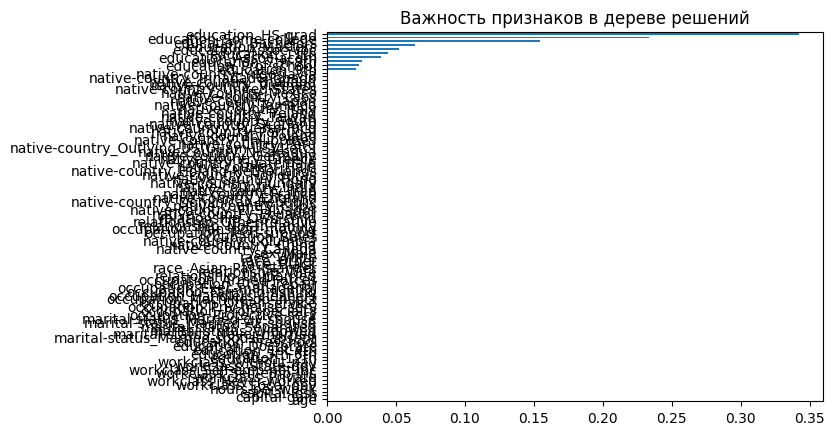

In [34]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

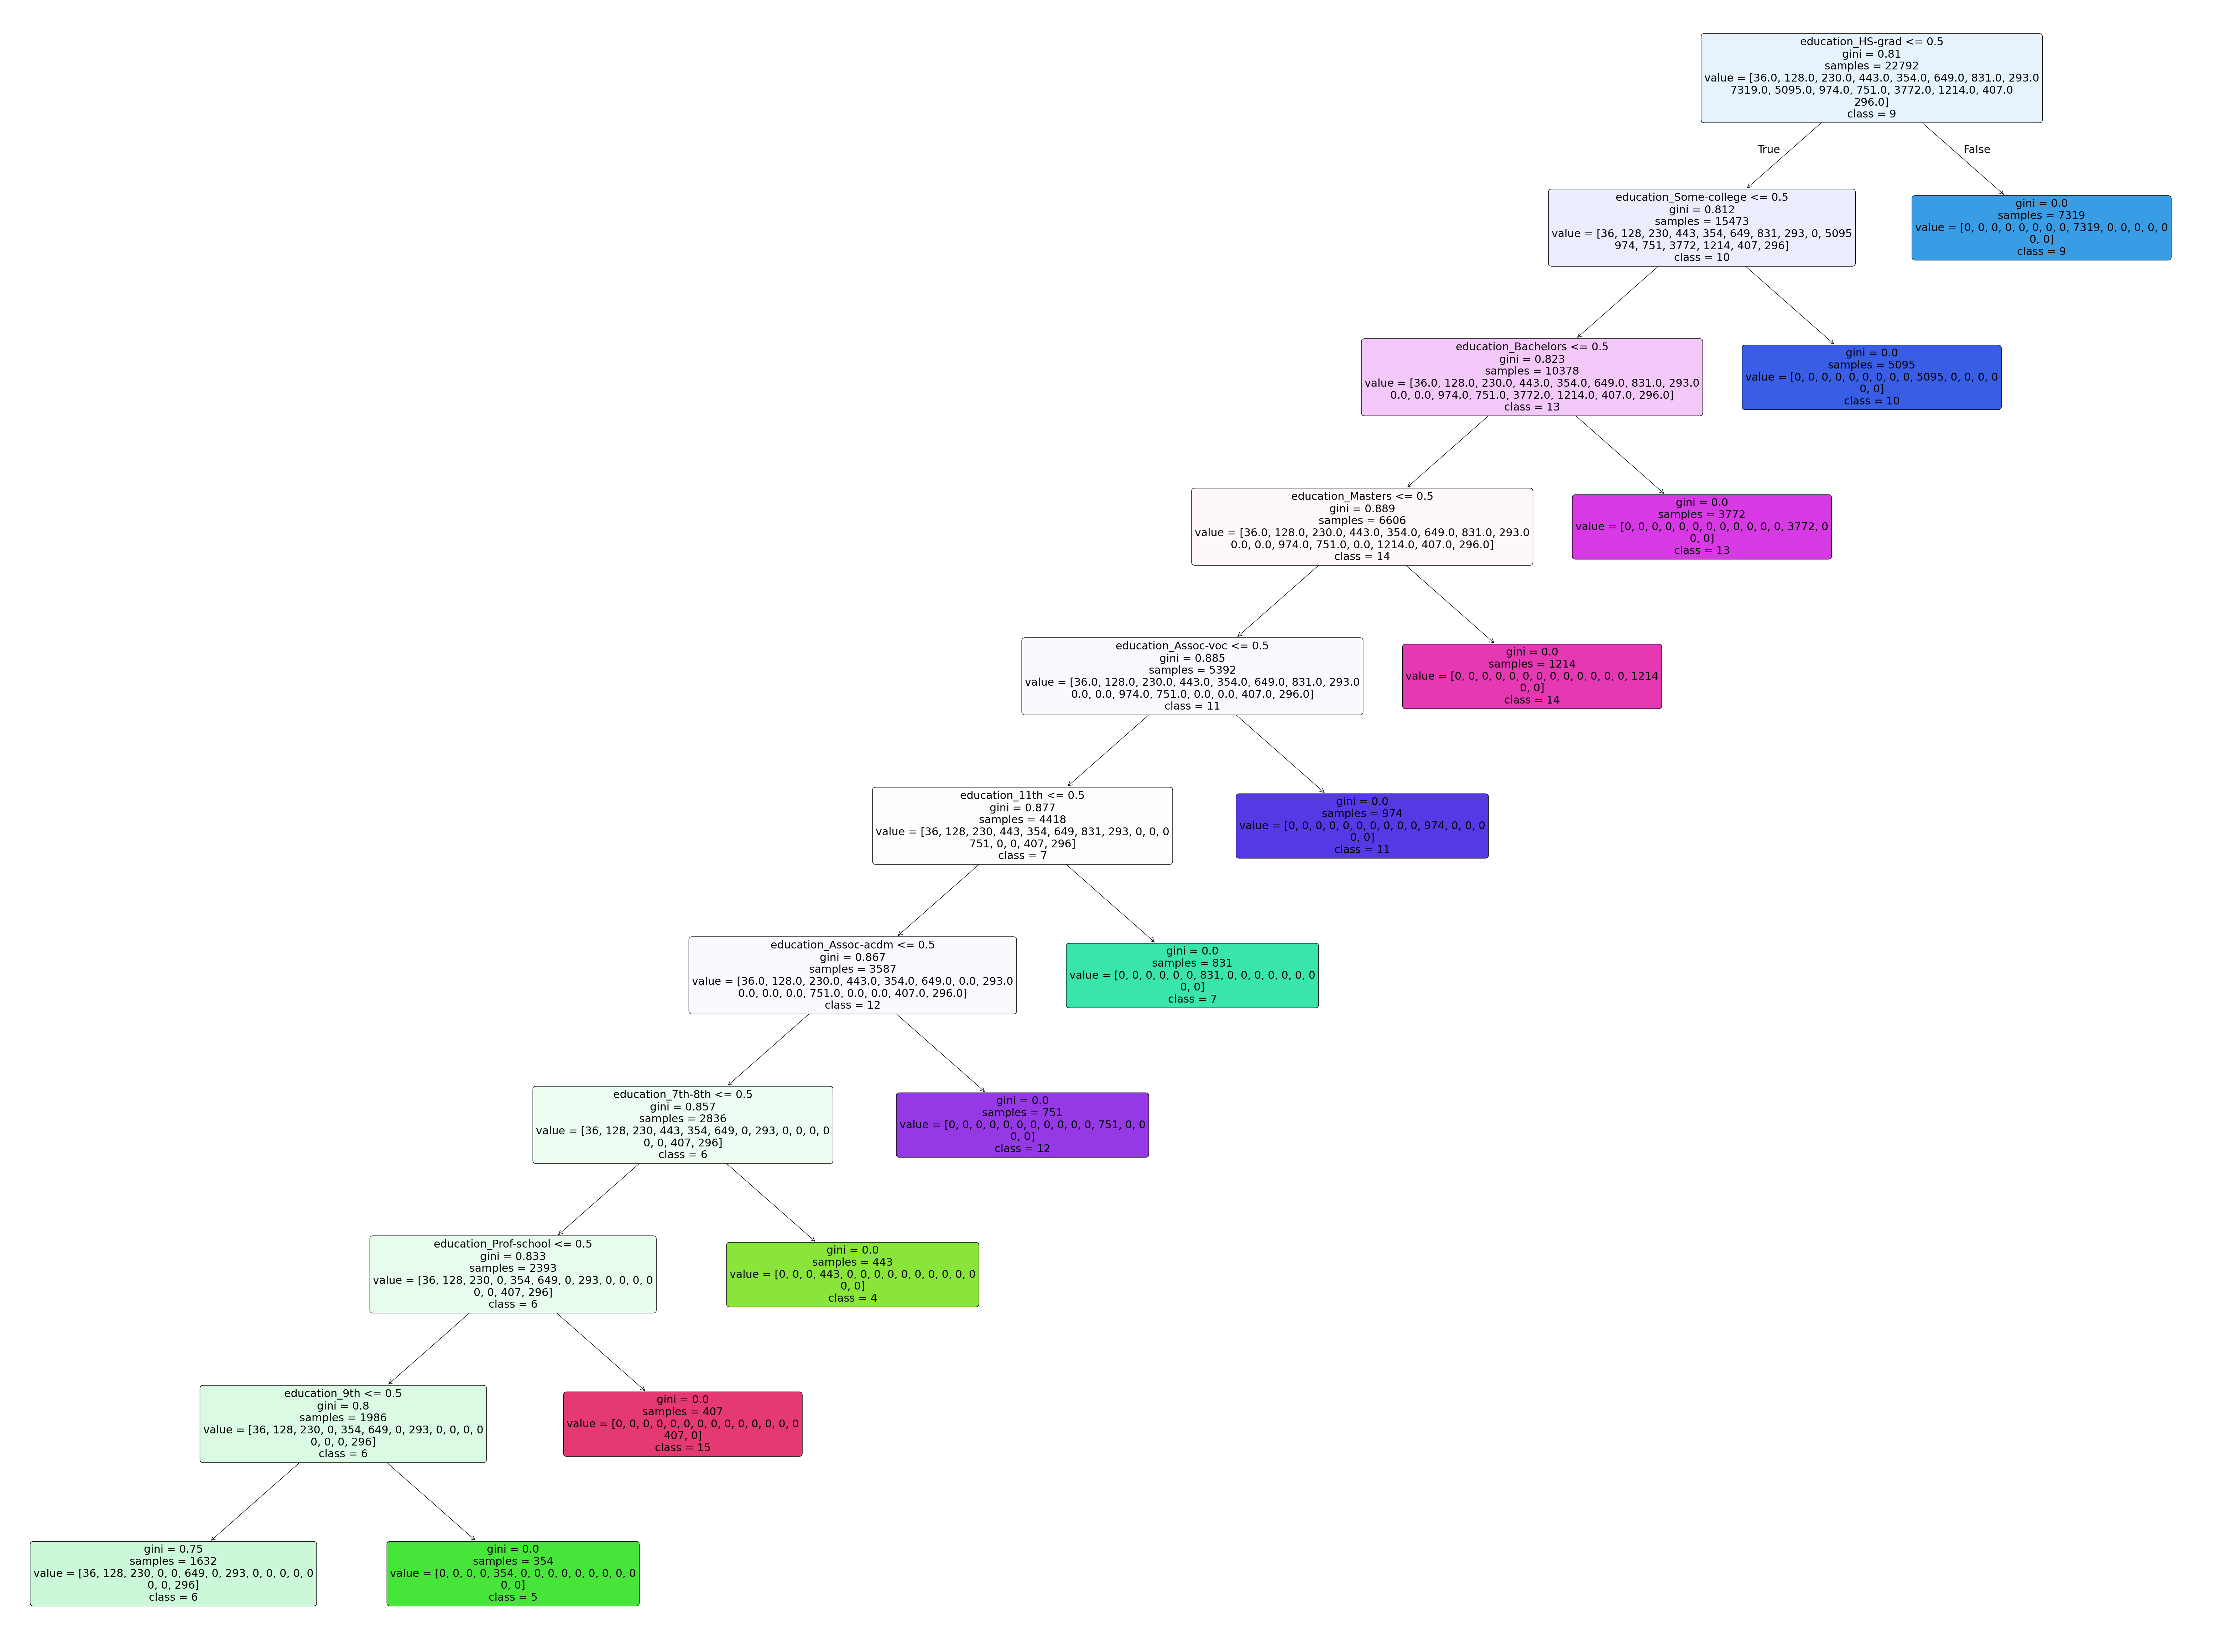

In [35]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(Y.unique())], filled=True, rounded=True)
plt.show()